In [23]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
PATH = os.path.dirname("C:\\Users\\lucas\\OneDrive\\Documentos\\SkinCancer\\data")

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


In [3]:
val_batches = tf.data.experimental.cardinality(test_dataset)
validation_dataset = test_dataset.take(val_batches // 5)
test_dataset = test_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 17


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [6]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [9]:
fine_tune_at = 100
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
from tensorflow.keras.layers import InputLayer 

dense_layer = tf.keras.layers.Dense(units = 1280, activation = "relu", input_shape=(1280,32))

prediction_layer = tf.keras.layers.Dense(1, activation = "sigmoid")
prediction_batch = prediction_layer(feature_batch_average)

In [13]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = dense_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [15]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

C:\Users\lucas\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\keras\backend.py:5090: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


4/4 [==============================] - 5s 347ms/step - loss: 0.7234 - accuracy: 0.4865


In [25]:
checkpoint_filepath = "checkpoint.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath,
    save_weights_only=True,
    monitor='train_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks=[model_checkpoint_callback])

Epoch 1/50
83/83 [==============================] - 55s 623ms/step - loss: 0.4263 - accuracy: 0.7869 - val_loss: 0.3584 - val_accuracy: 0.8438
Epoch 2/50
83/83 [==============================] - 52s 621ms/step - loss: 0.3118 - accuracy: 0.8544 - val_loss: 0.2738 - val_accuracy: 0.8516
Epoch 3/50
83/83 [==============================] - 51s 617ms/step - loss: 0.2732 - accuracy: 0.8779 - val_loss: 0.3170 - val_accuracy: 0.8594
Epoch 4/50
83/83 [==============================] - 51s 619ms/step - loss: 0.2570 - accuracy: 0.8889 - val_loss: 0.2710 - val_accuracy: 0.8984
Epoch 5/50
83/83 [==============================] - 52s 623ms/step - loss: 0.2180 - accuracy: 0.9006 - val_loss: 0.2696 - val_accuracy: 0.8750
Epoch 6/50
83/83 [==============================] - 52s 620ms/step - loss: 0.1931 - accuracy: 0.9177 - val_loss: 0.3803 - val_accuracy: 0.8359
Epoch 7/50
83/83 [==============================] - 52s 620ms/step - loss: 0.1712 - accuracy: 0.9261 - val_loss: 0.3259 - val_accuracy: 0.8828

In [18]:
model.load_weights(checkpoint_filepath)

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 7s 390ms/step - loss: 0.3957 - accuracy: 0.8759
Test accuracy : 0.8759398460388184


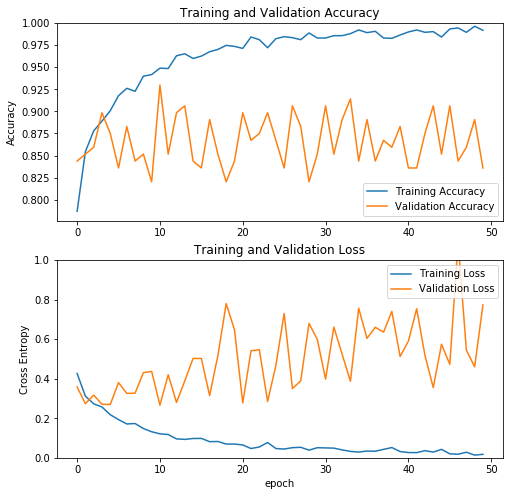

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()